<a href="https://colab.research.google.com/github/DILSHAN565/FYP_DL_Models/blob/main/For_Report_VIT_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Open In Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# Define the path to the directory containing your dataset
directory_path = '/content/drive/My Drive/Tea-Leaf-Diseases-Dataset'

# List all files in the directory
files = os.listdir(directory_path)

# Print the list of files
print(files)

['train', 'validation', 'test']


In [4]:
# Install necessary packages
!pip -q install vit_keras tensorflow-addons
!pip -q install --upgrade --no-cache-dir gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 5.5 MB/s eta 0:00:00


In [5]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from vit_keras import vit
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
SEED = 42
np.random.seed(SEED)

In [7]:
# Insert the Dataset path here
train_path = '/content/drive/MyDrive/Tea-Leaf-Diseases-Dataset/train'
val_path = '/content/drive/MyDrive/Tea-Leaf-Diseases-Dataset/validation'
test_path = '/content/drive/MyDrive/Tea-Leaf-Diseases-Dataset/test'


In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                   rotation_range=360,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   fill_mode='nearest',
                                   brightness_range=[0.8, 1.4],
                                   vertical_flip=True,
                                   horizontal_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)

Found 566 images belonging to 8 classes.
Found 123 images belonging to 8 classes.
Found 124 images belonging to 8 classes.


In [10]:
def create_model():
    vit_model = vit.vit_b16(
        image_size=IMAGE_SIZE,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False)

    model = tf.keras.Sequential([
        vit_model,
        Flatten(),
        Dense(8, activation='softmax') # Change to 8 for tea leaf disease classification
    ])

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])

    return model

In [11]:
model = create_model()
model.summary()

347502902/347502902 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 8)                 6152      
                                                                 
Total params: 85804808 (327.32 MB)
Trainable params: 85804808 (327.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger


In [13]:
# Define the directory for saving model artifacts
save_dir = '/content/drive/MyDrive/For-Report/VIT-Modified'

# Ensure the base directory exists
os.makedirs(save_dir, exist_ok=True)

# Specific directory for saving weights
weights_dir = os.path.join(save_dir, 'weights')
os.makedirs(weights_dir, exist_ok=True)

# Directory for logging CSV data
logs_dir = os.path.join(save_dir, 'logs')
os.makedirs(logs_dir, exist_ok=True)

In [14]:
# ModelCheckpoint: Save the best model weights
model_checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(weights_dir, 'ViT_weights-{epoch:02d}.h5'),
    save_weights_only=True,
    monitor='val_loss',  # Change to 'val_loss' if you want to monitor validation loss instead
    mode='min',  # Use 'min' if monitoring 'val_loss'
    save_best_only=True,
    verbose=1
)

# ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1
)

# CSVLogger: Log training data into a CSV file
csv_logger_callback = CSVLogger(
    os.path.join(logs_dir, 'training_log.csv')
)

# EarlyStopping: Stop training when a monitored metric has stopped improving
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)

# Combine all callbacks
callbacks = [
    model_checkpoint_callback,
    reduce_lr_callback,
    csv_logger_callback,
    early_stopping_callback
]


In [15]:
# Now, you can use this `callbacks` list when fitting your model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/100
35/35 [==============================] - ETA: 0s - loss: 1.2711 - categorical_accuracy: 0.5545
Epoch 1: val_loss improved from inf to 1.10607, saving model to /content/drive/MyDrive/For-Report/VIT-Modified/weights/ViT_weights-01.h5
35/35 [==============================] - 443s 11s/step - loss: 1.2711 - categorical_accuracy: 0.5545 - val_loss: 1.1061 - val_categorical_accuracy: 0.5893 - lr: 1.0000e-04
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 0.6248 - categorical_accuracy: 0.7509
Epoch 2: val_loss improved from 1.10607 to 0.68709, saving model to /content/drive/MyDrive/For-Report/VIT-Modified/weights/ViT_weights-02.h5
35/35 [==============================] - 61s 2s/step - loss: 0.6248 - categorical_accuracy: 0.7509 - val_loss: 0.6871 - val_categorical_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 0.4767 - categorical_accuracy: 0.8073
Epoch 3: val_loss improved from 0.68709 to 0.44807, saving 

In [16]:
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    plt.title(title)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.ylim(0, 1)
    plt.legend(['train_accuracy', 'val_accuracy'], loc='best')
    plt.show()

def plot_loss(history, title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.ylim(0, 1)
    plt.legend(['train_loss', 'val_loss'], loc='best')
    plt.show()

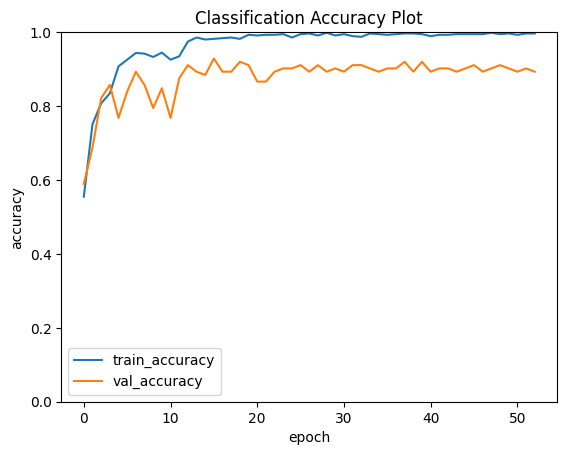

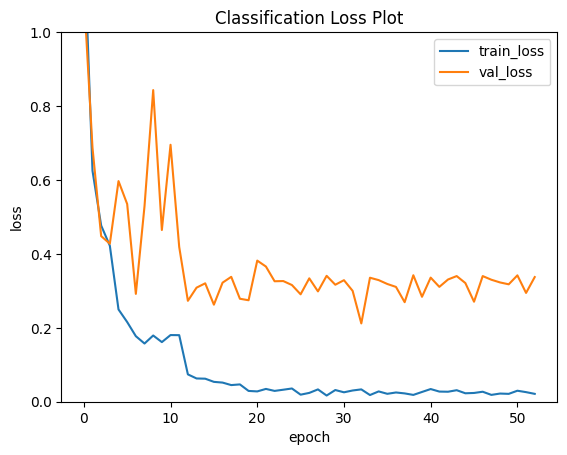

In [17]:
plot_accuracy(history, 'Classification Accuracy Plot')
plot_loss(history, 'Classification Loss Plot')

In [ ]:

#model = create_model()
model.load_weights('/content/drive/MyDrive/For-Report/VIT-Modified_b=8/weights/MobileNet_weights-37.h5')


In [18]:

#model = create_model()
model.load_weights('/content/drive/MyDrive/For-Report/VIT-Modified/weights/ViT_weights-33.h5')


In [19]:
# Assume the model.predict() call returns a predictions object
predictions = model.predict(test_generator, verbose=0)

# Getting the index of the highest probability class per image
y_pred = np.argmax(predictions, axis=1)

# Getting the true labels per image
y_true = test_generator.classes

# Getting the class names (labels) from the generator
class_names = list(test_generator.class_indices.keys())

# Printing the classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.80      1.00      0.89        12
           2       0.94      1.00      0.97        15
           3       0.83      0.88      0.86        17
           4       1.00      0.73      0.85        15
           5       1.00      1.00      1.00        12
           6       1.00      1.00      1.00        18
           7       0.84      0.73      0.78        22

    accuracy                           0.90       124
   macro avg       0.90      0.91      0.90       124
weighted avg       0.90      0.90      0.89       124



In [20]:

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

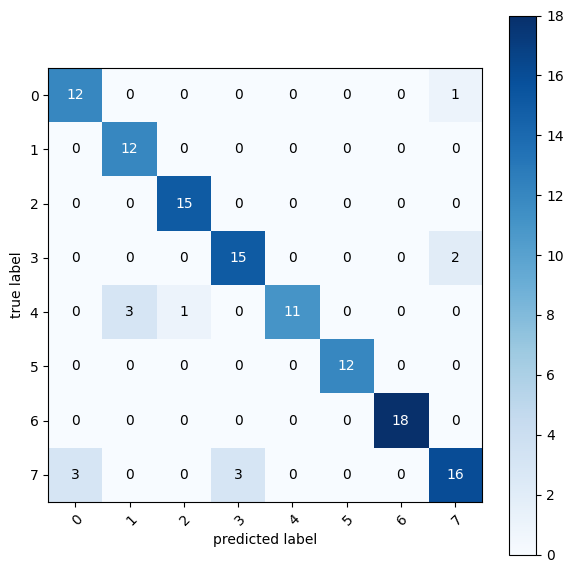

In [22]:
# Compute confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using mlxtend's `plot_confusion_matrix`
figure, ax = plot_confusion_matrix(conf_mat=cm,
                                   show_absolute=True,
                                   show_normed=False,
                                   colorbar=True,
                                   class_names=class_names,
                                   figsize=(7, 7))
plt.show()